<a href="https://colab.research.google.com/github/muhammadanas25/Stock_trend_prediction/blob/main/CART_stock_model_%2B_Ensemble_(adaboost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#run
# Initial imports
import pandas as pd
!pip install path
from path import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
# Initial imports
import pandas as pd
import numpy as np
from path import Path
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics,tree
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
%pip install path
from sklearn.compose import make_column_selector as selector
import matplotlib.pyplot as plt 

In [16]:
#run
# Loading data
#run
file_path = Path("TWTR.csv")
df = pd.read_csv(file_path)
df.dropna(inplace=True)
if(df.value_counts().min()<10):
  df=df[df.FutureTrend!="Neutral"].dropna()



df.tail()

,Date,Open,High,Low,Close,Volume,EF_1,EF_2,Oil FutureTrend,Gold FutureTrend,Trend,Twitter Sentiments,FutureTrend
749,23/06/2021,63.910000,66.769997,63.790001,66.489998,18548000,0.906041,4.036924,Negative,Positive,Positive,0,Negative
750,24/06/2021,66.750000,68.739998,66.750000,68.250000,23144800,0.753770,2.247191,Negative,Negative,Positive,0,Positive
751,25/06/2021,68.290001,68.919998,67.279999,67.930000,13896900,0.396343,-0.527164,Positive,Negative,Negative,0,Negative
752,28/06/2021,68.160004,68.629997,67.080002,68.290001,11176100,0.780647,0.190724,Negative,Positive,Positive,0,Negative
753,29/06/2021,68.279999,69.379997,67.930000,69.000000,9526400,0.737932,1.054483,Negative,Negative,Positive,0,Positive


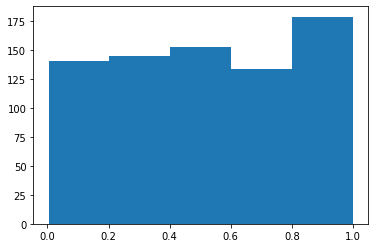

In [18]:
import matplotlib.pyplot as plt
mpgs = df['EF_1']
plt.hist(mpgs, bins=5)
plt.show()

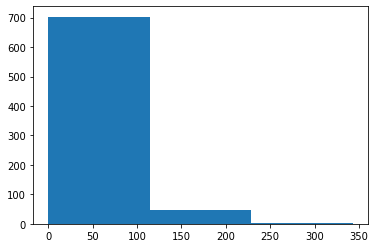

[  0.         114.33333333 228.66666667 343.        ]


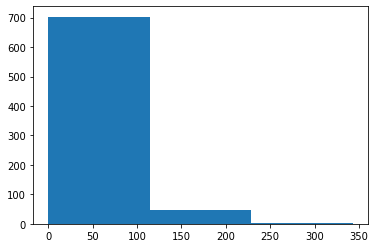

In [19]:
import matplotlib.pyplot as plt
mpgs = df['Twitter Sentiments']
plt.hist(mpgs, bins=3)
plt.show()
print(plt.hist(mpgs, bins=3)[1]
)

array([  0. ,  68.6, 137.2, 205.8, 274.4, 343. ])

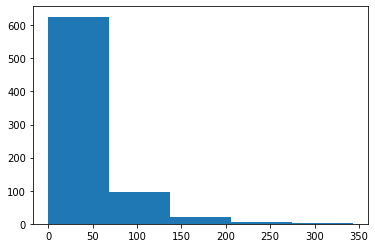

In [20]:
plt.hist(mpgs, bins=5)[1]


In [21]:
def make_bins(df):
   label_names = ["Ef_1_v_low","Ef_1_low","Ef_1_v_med","Ef1_high", "Ef1_very_high" ]
   cut_points =[0. , 0.2, 0.4, 0.6, 0.8, 1. ]
   df["EF_1_val"] = pd.cut(df["EF_1"], cut_points, labels=label_names)
   dummies = pd.get_dummies(df["EF_1_val"],drop_first=True)
   df = pd.concat([df, dummies], axis=1)
   label_names = ["setinent_neutral","sentiment_good","sentiment_bad"]
   cut_points =[0, 0.29,0.58 ,0.87] 
   df["sentiments"]=pd.cut(df['Twitter Sentiments'], cut_points, labels=label_names)
   dummies1 = pd.get_dummies(df["sentiments"],drop_first=True)
   df = pd.concat([df, dummies1], axis=1)
   df.drop(["EF_1_val","sentiments"],axis=1,inplace=True)
   return df

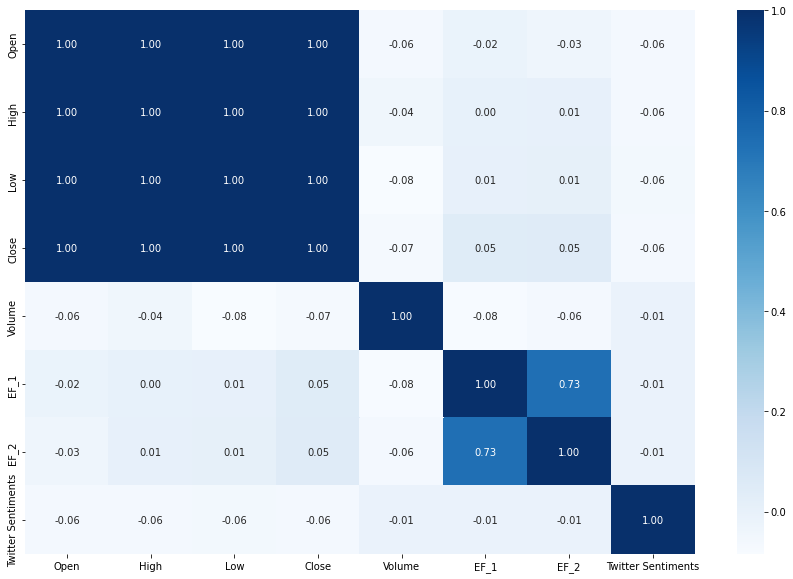

In [22]:
import seaborn as sns



fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df.corr(), annot = True , fmt=".2f",ax=ax ,cmap = "Blues")
plt.show()


In [23]:
df.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'EF_1', 'EF_2',
       'Oil FutureTrend', 'Gold FutureTrend', 'Trend', 'Twitter Sentiments',
       'FutureTrend'],
      dtype='object')

In [24]:
#OHLC Chart with Volume
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update_layout(title_text="HPQ Volume")
fig.update(layout_xaxis_rangeslider_visible=False) 
fig.show()

In [25]:
#run
target=df['FutureTrend']
df=df.drop("FutureTrend",axis =1)
target= target.replace(['Negative','Positive',  'Neutral'],[0,1,2])


In [26]:
target.value_counts()

0    408
1    344
Name: FutureTrend, dtype: int64

In [27]:
# Setting Index as Date
from sklearn.preprocessing import OrdinalEncoder

appl_df = make_bins(df)
appl_df.head(2)
appl_df=appl_df.drop(["Twitter Sentiments"],axis =1)
appl_df['diff']=appl_df['Close']-appl_df['Open']
appl_df['10day']=appl_df['Close'].rolling(10).mean()
appl_df['10day'].fillna(appl_df['10day'][9],inplace=True)
appl_df = appl_df.set_index("Date")

appl_df.tail()
new_df=appl_df
print(new_df.isna().sum())
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(new_df)
categorical_columns = categorical_columns_selector(new_df)

# print(categorical_columns)
# preprocessor = ColumnTransformer([
#     ('one-hot-encoder', categorical_preprocessor, categorical_columns)])
#     ('standard-scaler', numerical_preprocessor, numerical_columns)])



enc = OrdinalEncoder()
new_df[[ 'Oil FutureTrend', 'Gold FutureTrend', 'Trend']] = enc.fit_transform(df[[ 'Oil FutureTrend', 'Gold FutureTrend', 'Trend']])



from imblearn.over_sampling import SMOTE
oversample = SMOTE()
new_df, target = oversample.fit_resample(new_df, target)

from scipy.stats import itemfreq
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
X_train,X_test, y_train, y_test = train_test_split(new_df, target, test_size=0.2, random_state=42)
 
model = DecisionTreeClassifier(criterion='entropy', max_depth=7,min_samples_split=10, random_state=0)
print(X_train.head())
model.fit(X_train,y_train)


Open                0
High                0
Low                 0
Close               0
Volume              0
EF_1                0
EF_2                0
Oil FutureTrend     0
Gold FutureTrend    0
Trend               0
Ef_1_low            0
Ef_1_v_med          0
Ef1_high            0
Ef1_very_high       0
sentiment_good      0
sentiment_bad       0
diff                0
10day               0
dtype: int64
          Open       High        Low      Close    Volume      EF_1      EF_2  \
448  26.860001  27.170000  25.959999  26.549999  21946600  0.487603 -1.154138   
335  29.959999  30.260000  29.410000  29.620001  22716700  0.247060 -1.134841   
294  42.380001  43.770000  41.639999  41.959999  16159600  0.150235 -0.991038   
684  64.949997  64.949997  62.049999  62.060001  15475500  0.003449 -4.449570   
79   28.480000  29.020000  28.070000  28.770000  26503600  0.736842  1.018262   

     Oil FutureTrend  Gold FutureTrend  Trend  Ef_1_low  Ef_1_v_med  Ef1_high  \
448  2.0              2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=0)

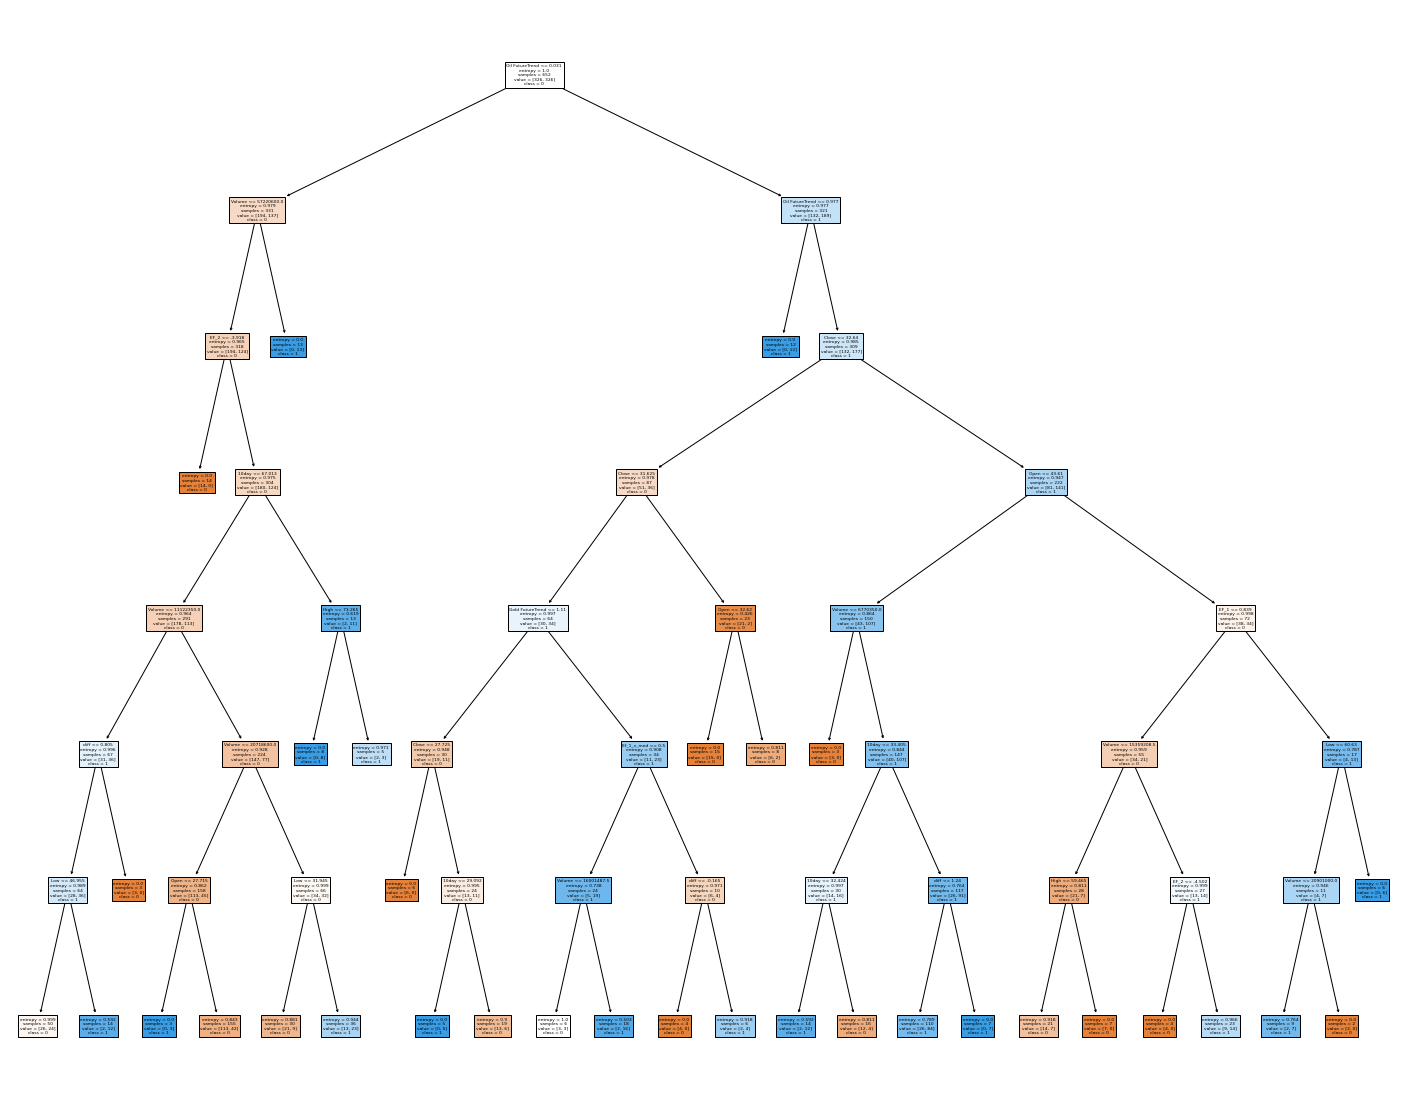

In [28]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=appl_df.columns,  
                   class_names=["0","1","2"],
                   filled=True)


In [29]:
print("Accuracy score (training): {0:.3f}".format(
        model.score(
            X_train, 
            y_train)))
print("Accuracy score (validation): {0:.3f}".format(
        model.score(
            X_test, 
            y_test)))


Accuracy score (training): 0.759
Accuracy score (validation): 0.500


Applying Hyper Paramter tuning 

In [30]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 9, 12],
              'min_samples_leaf': [5, 10, 20, 50, 100],
              'criterion' :['gini', 'entropy']
             }

In [31]:
dt = DecisionTreeClassifier()

In [32]:
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=param_grid, 
                           cv=4, n_jobs=-1,error_score='raise', verbose=1, scoring = "accuracy")


In [33]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 450 candidates, totalling 1800 fits


GridSearchCV(cv=4, error_score='raise', estimator=DecisionTreeClassifier(),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 9, 12],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [34]:
final_model = grid_search.best_estimator_
final_model


DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=5,
                       max_features='sqrt', min_samples_leaf=10)

In [35]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006874,0.002275,0.005261,0.002719,0.1,gini,5,auto,5,"{'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5}",0.496933,0.496933,0.496933,0.496933,0.496933,0.0,300
1,0.006361,0.002007,0.004338,0.002069,0.1,gini,5,auto,10,"{'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 10}",0.496933,0.496933,0.496933,0.496933,0.496933,0.0,300
2,0.006276,0.002520,0.002898,0.000093,0.1,gini,5,auto,20,"{'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 20}",0.496933,0.496933,0.496933,0.496933,0.496933,0.0,300
3,0.004771,0.000111,0.004045,0.001989,0.1,gini,5,auto,50,"{'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 50}",0.496933,0.496933,0.496933,0.496933,0.496933,0.0,300
4,0.004523,0.000078,0.003096,0.000481,0.1,gini,5,auto,100,"{'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 100}",0.496933,0.496933,0.496933,0.496933,0.496933,0.0,300


In [36]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
231,0.006642,0.001768,0.002830,0.000125,0.01,entropy,5,sqrt,10,"{'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10}",0.558282,0.595092,0.607362,0.656442,0.604294,0.035109,1
358,0.004519,0.000110,0.002792,0.000048,0.001,gini,9,log2,50,"{'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 50}",0.552147,0.595092,0.619632,0.619632,0.596626,0.027565,2
418,0.004932,0.000205,0.004393,0.002373,0.001,entropy,7,log2,50,"{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 50}",0.558282,0.607362,0.582822,0.638037,0.596626,0.029542,2
403,0.004727,0.000149,0.002922,0.000122,0.001,entropy,6,log2,50,"{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 50}",0.509202,0.619632,0.619632,0.631902,0.595092,0.049841,4
150,0.004896,0.000156,0.004049,0.002062,0.01,gini,5,auto,5,"{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5}",0.558282,0.595092,0.588957,0.631902,0.593558,0.026164,5


In [37]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

In [38]:


evaluate_model(final_model)



Train Accuracy : 0.6012269938650306
Train Confusion Matrix:
[[287  39]
 [221 105]]
--------------------------------------------------
Test Accuracy : 0.524390243902439
Test Confusion Matrix:
[[65 17]
 [61 21]]


In [39]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

  
seed = 8
kfold = model_selection.KFold(n_splits = 5,
                       )
  
# initialize the base classifier
base_cls = final_model
  
# no. of base classifier
num_trees = 500
for num_trees in [50,100,250,300,400,500]:
# bagging classifier
  model_3 = BaggingClassifier(base_estimator = base_cls,
                            n_estimators = num_trees,
                            random_state = seed)
  X_train,X_test, y_train, y_test = train_test_split(new_df, target, test_size=0.2, random_state=42)

  model_3.fit(X_train,y_train)
  print("Accuracy score (training): {0:.3f}".format(
        model_3.score(
            X_train, 
            y_train)))
  print("Accuracy score (validation): {0:.3f}".format(
        model_3.score(
            X_test, 
            y_test)))
  # results = model_selection.cross_val_score(model_3, X_train, y_train, cv = kfold)
  # print("accuracy :")
  # print("num_trees :",num_trees,results.mean())

Accuracy score (training): 0.706
Accuracy score (validation): 0.512
Accuracy score (training): 0.712
Accuracy score (validation): 0.476
Accuracy score (training): 0.712
Accuracy score (validation): 0.524
Accuracy score (training): 0.713
Accuracy score (validation): 0.524
Accuracy score (training): 0.712
Accuracy score (validation): 0.518
Accuracy score (training): 0.718
Accuracy score (validation): 0.506


In [40]:
%pip install lgbm
import lightgbm as lgbm
model_2 =lgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=70,
                                learning_rate=0.4, n_estimators=50, max_depth=3,
                                bagging_fraction=0.6,
                             reg_alpha=0.8
                                ,reg_lambda=0.8,class_weight='balanced')
                        

model_2.fit(X_train,y_train)

  # Scoring the model_2
print("Accuracy score (training): {0:.3f}".format(
        model_2.score(
            X_train, 
            y_train)))
print("Accuracy score (validation): {0:.3f}".format(
        model_2.score(
            X_test, 
            y_test)))

ERROR: Could not find a version that satisfies the requirement lgbm (from versions: none)
ERROR: No matching distribution found for lgbm
Accuracy score (training): 0.879
Accuracy score (validation): 0.512


XGboost

In [41]:
from xgboost import XGBClassifier
from numpy import mean
from numpy import std
model = XGBClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.590 (0.044)


In [42]:

model =DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=6,
                       max_features='auto', random_state=0)
model.fit (X_train,y_train)
model.score(X_test,y_test)

0.5121951219512195

Adaboost

In [43]:

appl_df = df
appl_df = appl_df.set_index("Date")
appl_df.tail()
new_df=appl_df
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(new_df)
categorical_columns = categorical_columns_selector(new_df)

# print(categorical_columns)
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns)])

In [44]:
model =make_pipeline(preprocessor,AdaBoostClassifier())
model.fit (X_train,y_train)
model.score(X_test,y_test)
print("Accuracy score (training): {0:.3f}".format(
        model.score(
            X_train, 
            y_train)))
print("Accuracy score (validation): {0:.3f}".format(
        model.score(
            X_test, 
            y_test)))

Accuracy score (training): 0.603
Accuracy score (validation): 0.549


Hyper parameter tuning on ada boost

In [45]:
def get_models():
	models = dict()
	# explore depths from 1 to 10
	for i in range(1,30,2):
		# define base model
		base = DecisionTreeClassifier(max_depth=i)
		# define ensemble model
		models[str(i)] = AdaBoostClassifier(base_estimator=base)
	return models
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 

>1 0.589 (0.052)
>3 0.541 (0.057)
>5 0.579 (0.055)
>7 0.578 (0.053)
>9 0.584 (0.053)
>11 0.573 (0.051)
>13 0.558 (0.054)
>15 0.532 (0.061)
>17 0.541 (0.049)
>19 0.537 (0.059)
>21 0.535 (0.056)
>23 0.539 (0.053)
>25 0.543 (0.059)
>27 0.546 (0.057)
>29 0.542 (0.056)


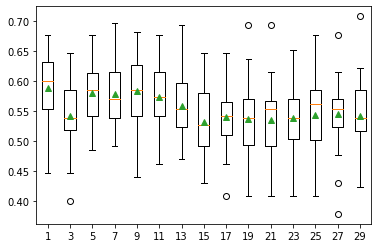

In [46]:
import matplotlib.pyplot as plt
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Adaboost Ensemble with Cart

In [47]:
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
# define the model with default hyperparameters
model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.597653 using {'learning_rate': 0.1, 'n_estimators': 100}
0.533155 (0.054270) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.533155 (0.054270) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.533155 (0.054270) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.532642 (0.053411) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.532642 (0.053411) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.532642 (0.053411) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.535703 (0.055795) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.555649 (0.071796) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.536729 (0.054982) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.556162 (0.071837) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.563838 (0.069755) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.597110 (0.043804) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.563877 (0.067360) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.596068

In [48]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}